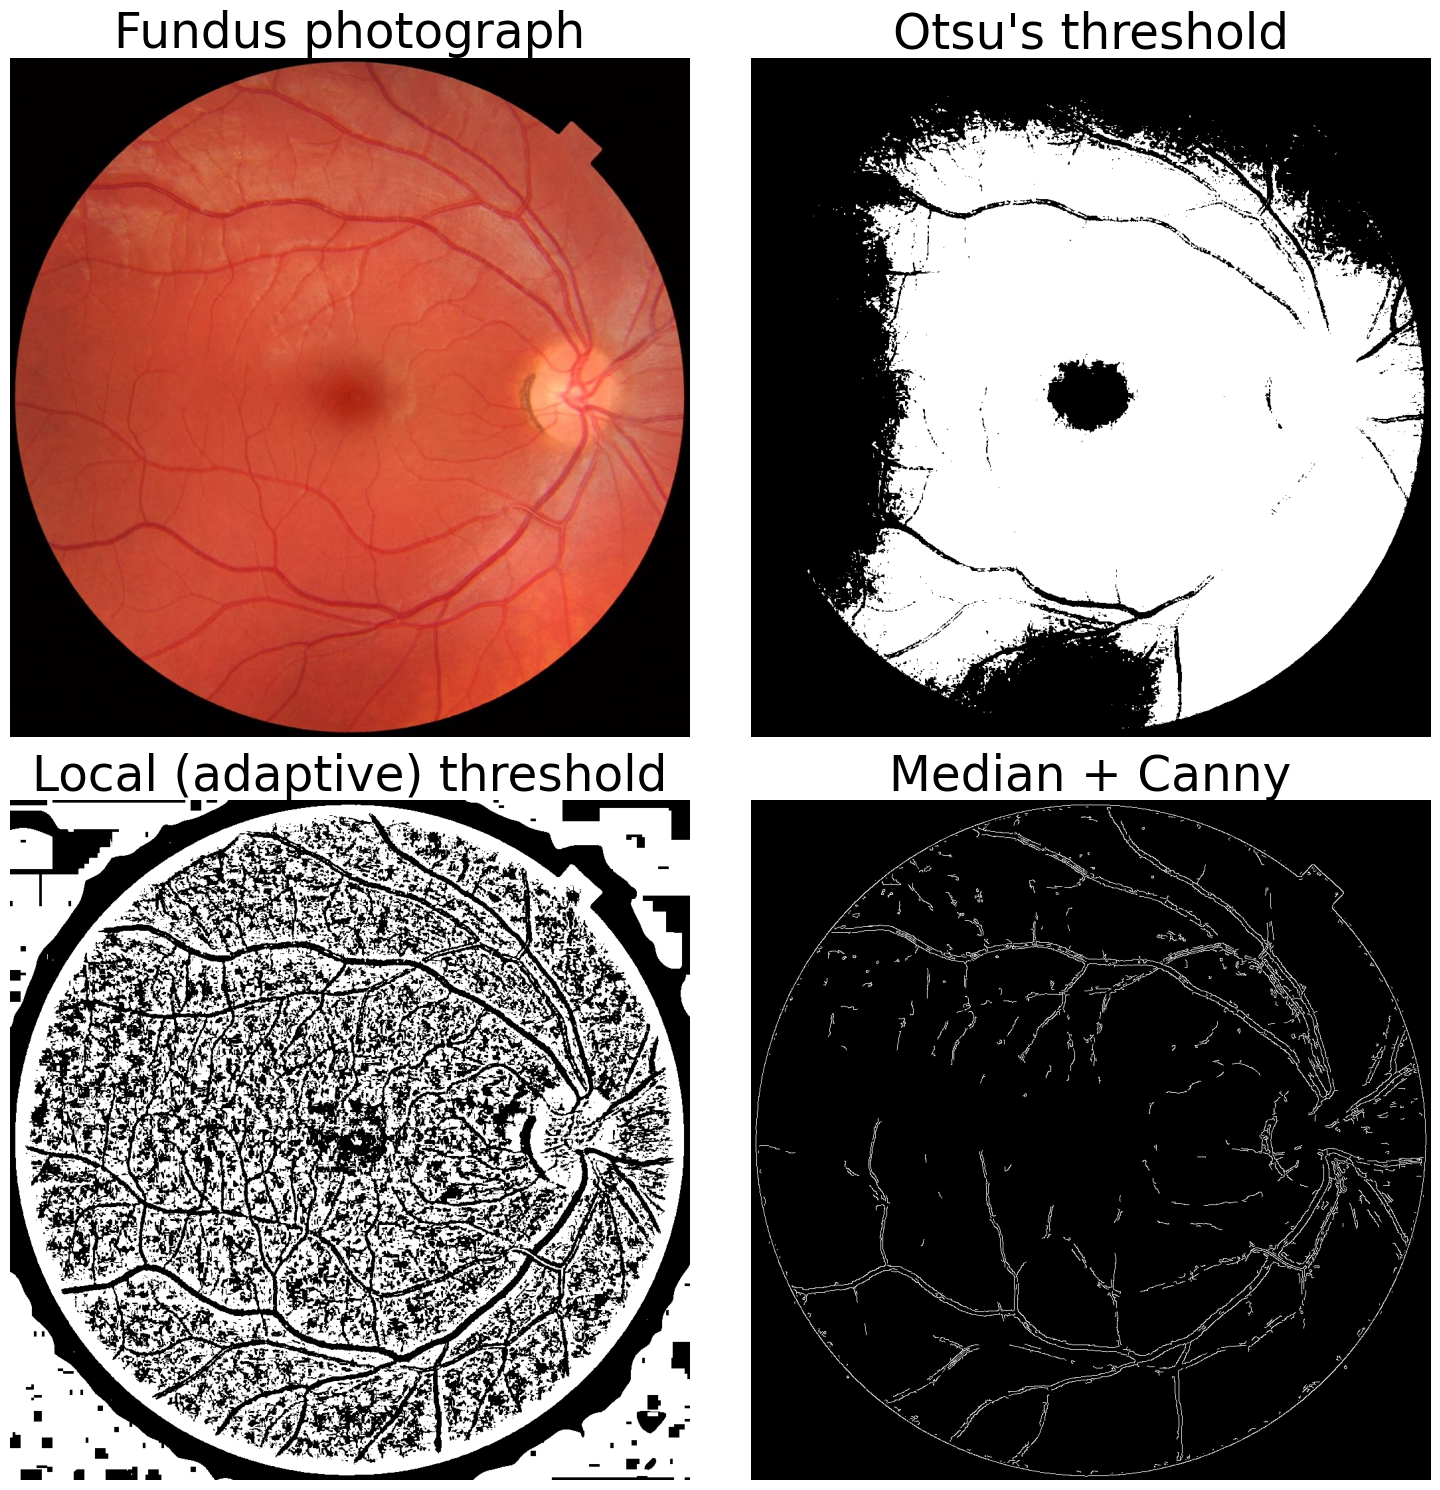

In [2]:
from skimage.io import imread
from skimage.filters import threshold_otsu, threshold_local, median
from skimage.feature import canny
import matplotlib.pyplot as plt
import numpy as np

retina = imread("Fundus_normal_right_eye_wikimedia.jpg")
thr = threshold_otsu(retina[:,:,0][retina[:,:,0]>10])
local_thr = threshold_local(retina[:,:,0], block_size=61, offset=0)
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

titles = ["Fundus photograph", "Otsu's threshold", "Local (adaptive) threshold", "Median + Canny"]

ax[0,0].imshow(retina)
ax[0,0].set_title(titles[0], fontsize=35)
ax[0,1].imshow(retina[:,:,0] > thr, cmap="gray")
ax[0,1].set_title(titles[1], fontsize=35)
ax[1,0].imshow(retina[:,:,0] > local_thr, cmap="gray")
ax[1,0].set_title(titles[2], fontsize=35)
ax[1,1].imshow(canny(median(retina[:,:,0], footprint=np.ones((2, 2))), sigma=.01), cmap="gray")
ax[1,1].set_title(titles[3], fontsize=35)

for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

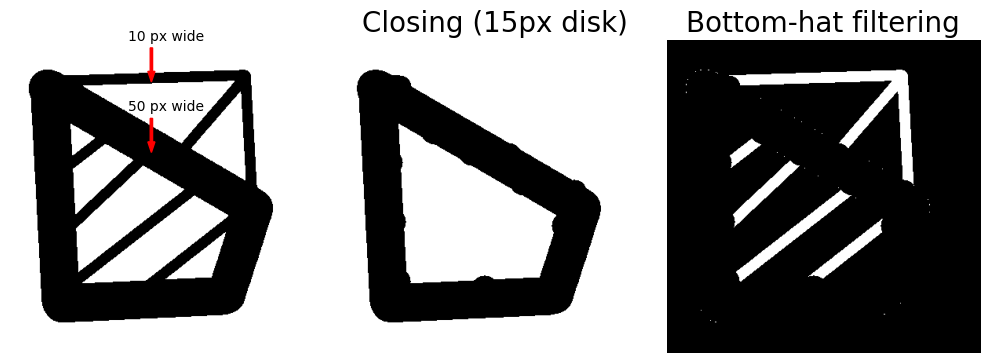

In [3]:
import numpy as np
from skimage.morphology import disk, binary_closing
from skimage.draw import line

img = imread("test_bh.png")
img = img[:,:,0].astype(bool)
img_close = binary_closing(img, disk(15))

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(img, cmap="gray")

ax[0].text(150, 0, "10 px wide")
ax[0].text(150, 90, "50 px wide")
ax[0].arrow(180, 10, 0, 30, width=3, color="red")
ax[0].arrow(180, 100, 0, 30, width=3, color="red")
ax[1].imshow(img_close, cmap="gray")
ax[1].set_title("Closing (15px disk)", fontsize=20)
ax[2].imshow(img_close ^ img, cmap="gray")
ax[2].set_title("Bottom-hat filtering", fontsize=20)

for a in ax:
    a.axis("off")

plt.tight_layout()



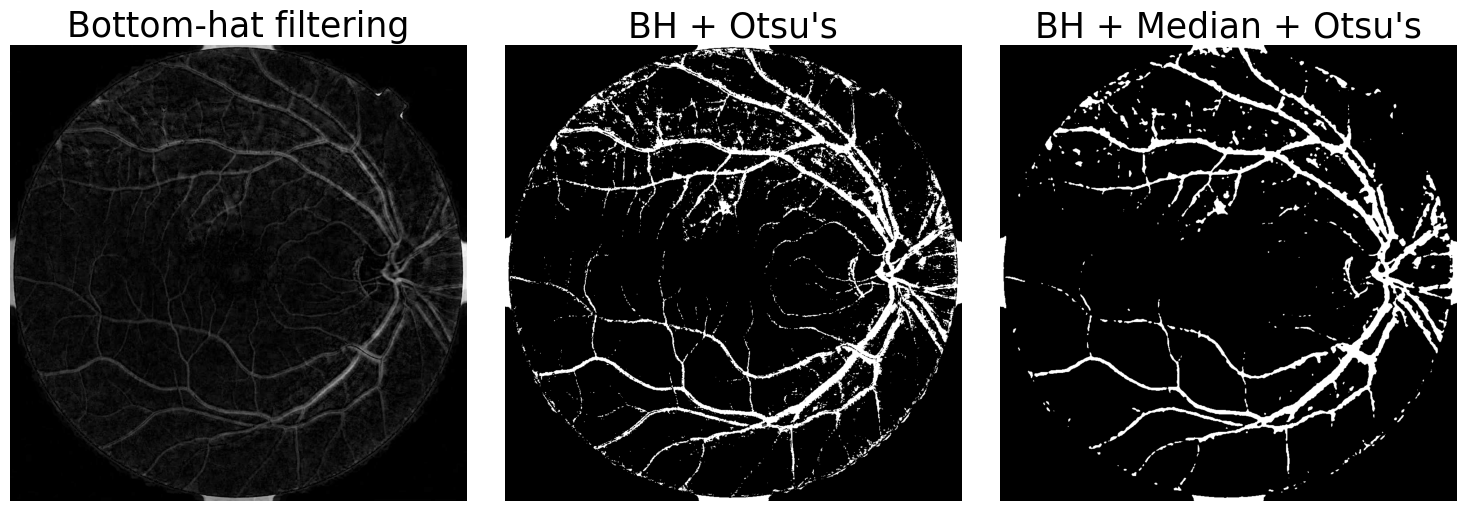

In [6]:
# Bottom-hat filtering
from skimage.morphology import closing, disk, skeletonize
from skimage.filters import unsharp_mask, median, threshold_otsu
from skimage import img_as_float

channel = 2
retina_bh = img_as_float(closing(retina[:,:,channel], footprint=disk(15))) - img_as_float(retina[:,:,channel])
retina_otsu = retina_bh > threshold_otsu(retina_bh)
retina_med_otsu = median(retina_bh, footprint=disk(3)) > threshold_otsu(retina_bh)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(retina_bh, cmap="gray")
ax[0].set_title("Bottom-hat filtering", fontsize=25)
ax[1].imshow(retina_otsu, cmap="gray")
ax[1].set_title("BH + Otsu's", fontsize=25)
ax[2].imshow(retina_med_otsu, cmap="gray")
ax[2].set_title("BH + Median + Otsu's", fontsize=25)

for a in ax:
    a.axis("off")

plt.tight_layout()

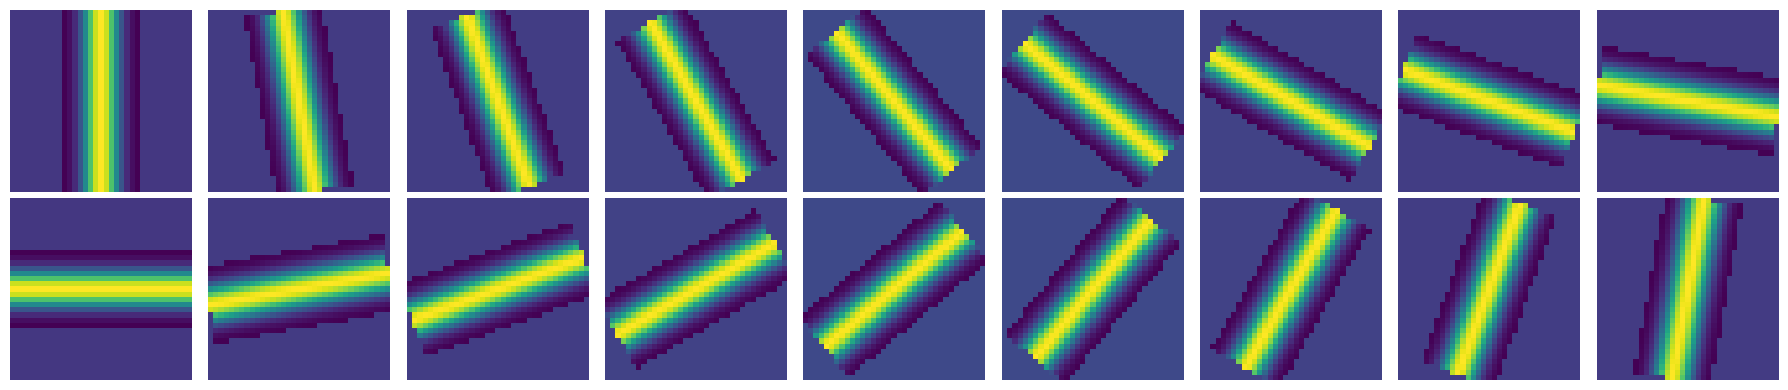

In [13]:
from skimage.feature import match_template
from skimage.filters.edges import convolve
from skimage import img_as_float, img_as_ubyte
from tqdm import tqdm

def vessel_template_matching_kernel(L, sigma=1.5, angle=0):
    """
    Create a vessel template matching kernel.
    """
    kernel = np.zeros((L, L))

    mx = max(np.ceil(3*sigma), (L-1)/2)

    # Non rotated coord system
    x, y = np.meshgrid(np.arange(-mx, mx+1), np.arange(-mx, mx+1))

    angle = np.deg2rad(angle)

    # Rotated coordinate system
    u = x * np.cos(angle) - y * np.sin(angle)
    v = x * np.sin(angle) + y * np.cos(angle)

    # Kernel domain
    N = (abs(u) <= 3*sigma) & (abs(v) <= L/2)

    # Kernel values
    K = np.exp((-pow(u, 2))/(2*pow(sigma, 2)))
    # Subtract the mean
    K -= np.mean(K)
    # Set kernel values outside the domain to zero
    K[~N] = 0

    return K


k = [vessel_template_matching_kernel(35, 2.5, theta)
     for theta in range(0, 180, 10)]

fig, ax = plt.subplots(2, 9, figsize=(18, 4))

for i, a in enumerate(ax.ravel()):
    a.imshow(k[i], cmap="viridis")
    a.axis("off")

plt.tight_layout()

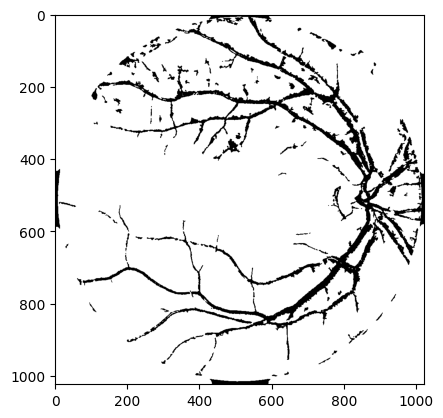

In [20]:
from skimage.transform import rescale
from skimage.morphology import disk, remove_small_objects
# Green channel
#im = retina[:, :, 1]
im = remove_small_objects(retina_otsu, min_size=50)
im = img_as_float(median(im))
im = 1.0 - img_as_float(im)

out = np.zeros_like(im)
plt.imshow(im, cmap="gray")
plt.show()

In [23]:
# Convolve all kernels with the image, then take the maximum
for kk in tqdm(k):
    res = convolve(im, kk)
    out = np.dstack([out, res])

out = np.max(out, axis=2)
out = out / np.max(out)

100%|██████████| 18/18 [00:05<00:00,  3.35it/s]


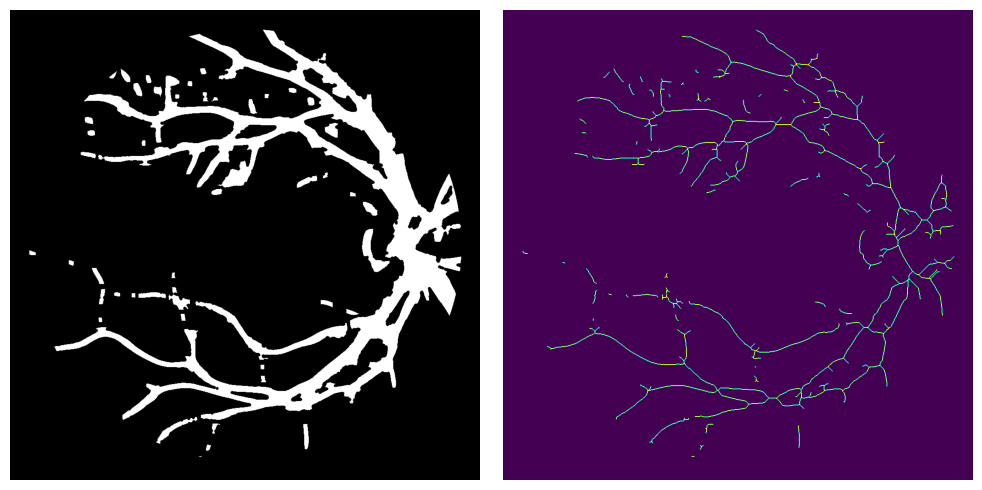

In [33]:
from skimage.morphology import skeletonize, remove_small_holes, remove_small_objects

segm = out < .8
segm = closing(segm, disk(3))
segm = remove_small_holes(segm, area_threshold=150)
segm = remove_small_objects(segm)

cx, cy = segm.shape[0]//2, segm.shape[1]//2
for x in range(segm.shape[0]):
    for y in range(segm.shape[1]):
        if (x-cx)**2 + (y-cy)**2 > (cx-1)**2*0.85:
            segm[x, y] = 0
skel = skeletonize(segm)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(segm, cmap="gray")
ax[1].imshow(skel, cmap="viridis", vmax=.5)

for a in ax:
    a.axis("off")
    
plt.tight_layout()

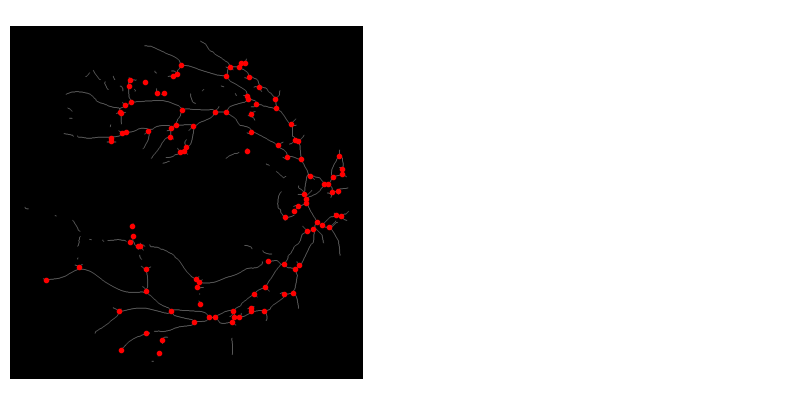

In [34]:
def get_neighbours(x,y,image):
    """Return 8-neighbours of image point P1(x,y), in a clockwise order"""
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1;
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1], img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]   


def getSkeletonIntersection(skeleton):
    """ Given a skeletonised image, it will give the coordinates of the intersections of the skeleton.

    Keyword arguments:
    skeleton -- the skeletonised image to detect the intersections of

    Returns: 
    List of 2-tuples (x,y) containing the intersection coordinates
    """
    # A biiiiiig list of valid intersections             2 3 4
    # These are in the format shown to the right         1 C 5
    #                                                    8 7 6 
    validIntersection = [[0,1,0,1,0,0,1,0],[0,0,1,0,1,0,0,1],[1,0,0,1,0,1,0,0],
                         [0,1,0,0,1,0,1,0],[0,0,1,0,0,1,0,1],[1,0,0,1,0,0,1,0],
                         [0,1,0,0,1,0,0,1],[1,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,1],
                         [0,1,0,1,0,0,0,1],[0,1,0,1,0,1,0,0],[0,0,0,1,0,1,0,1],
                         [1,0,1,0,0,0,1,0],[1,0,1,0,1,0,0,0],[0,0,1,0,1,0,1,0],
                         [1,0,0,0,1,0,1,0],[1,0,0,1,1,1,0,0],[0,0,1,0,0,1,1,1],
                         [1,1,0,0,1,0,0,1],[0,1,1,1,0,0,1,0],[1,0,1,1,0,0,1,0],
                         [1,0,1,0,0,1,1,0],[1,0,1,1,0,1,1,0],[0,1,1,0,1,0,1,1],
                         [1,1,0,1,1,0,1,0],[1,1,0,0,1,0,1,0],[0,1,1,0,1,0,1,0],
                         [0,0,1,0,1,0,1,1],[1,0,0,1,1,0,1,0],[1,0,1,0,1,1,0,1],
                         [1,0,1,0,1,1,0,0],[1,0,1,0,1,0,0,1],[0,1,0,0,1,0,1,1],
                         [0,1,1,0,1,0,0,1],[1,1,0,1,0,0,1,0],[0,1,0,1,1,0,1,0],
                         [0,0,1,0,1,1,0,1],[1,0,1,0,0,1,0,1],[1,0,0,1,0,1,1,0],
                         [1,0,1,1,0,1,0,0]];
    image = skeleton.copy();
    intersections = list();
    for x in range(1,len(image)-1):
        for y in range(1,len(image[x])-1):
            # If we have a white pixel
            if image[x][y] == 1:
                neighbours = get_neighbours(x,y,image);
                valid = True;
                if neighbours in validIntersection:
                    intersections.append((y,x));
    # Filter intersections to make sure we don't count them twice or ones that are very close together
    for point1 in intersections:
        for point2 in intersections:
            if (((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2) and (point1 != point2):
                intersections.remove(point2);
    # Remove duplicates
    intersections = list(set(intersections));
    return intersections;

intersections = getSkeletonIntersection(skeleton=skel.astype(int))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(skel, cmap="gray")

# Add intersections and endpoints on top of the skeleton
for point in intersections:
    ax[0].plot(point[0], point[1], 'r.')

for a in ax:
    a.axis("off")

plt.show()




100%|██████████| 106/106 [00:26<00:00,  4.02it/s]

Created a graph with 6 nodes and 3 edges


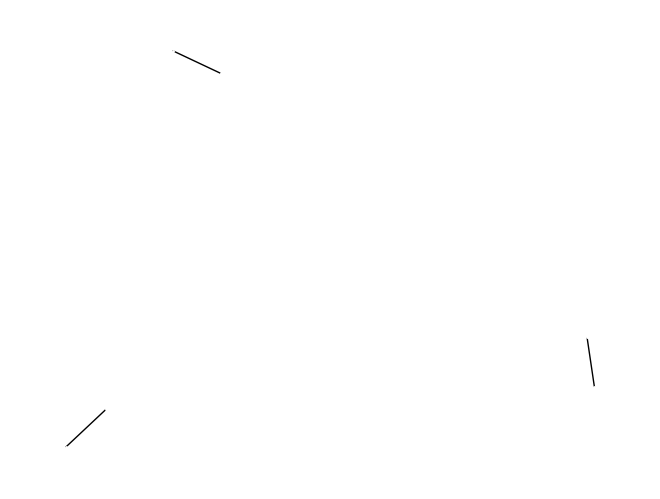

In [35]:
from skimage.draw import line
from skimage.morphology import binary_dilation, disk
import networkx as nx

def is_connected(node1, node2, skeleton, threshold = 0.4):
    """
    Return true if there is a line between the two nodes in a skeleton image

    Args:
        node1 ((int, int)): the coordinates of node 1
        node2 ((int, int)): the coordinates of node 2
        skeleton (numpy.ndarray): the skeleton image
        threshold (float): the % of pixels between the two nodes that need to be 1 in the skeleton for them to be connected

    Returns:
        bool: True if there is a line between the two nodes, False otherwise
    """

    # Create a mask with a line between the two points using skimage
    mask = np.zeros(skeleton.shape, dtype=np.uint8)
    rr, cc = line(node1[1], node1[0], node2[1], node2[0])
    # Thicken the line
    mask[rr, cc] = 1
    mask = binary_dilation(mask, disk(1))

    
    # Return the % of the skeleton that is 1 when masked with the mask
    percent = sum(skeleton[mask==1]) / sum(mask.ravel())
    
    return percent > threshold

# Create a networkx graph from the skeleton
# Check which of the nodes are connected to each other
nx_graph = nx.Graph()
max_distance = 100

for i1, node1 in enumerate(tqdm(intersections[:-1])):
    for i2, node2 in enumerate(intersections[i1:]):
        if node1 != node2:
            # Check distance
            if (node1[0] - node2[0])**2 + (node1[1] - node2[1])**2 < max_distance**2:
                if is_connected(node1, node2, skel):
                    # print(f"Nodes {i1} and {i2} are connected")
                    nx_graph.add_edge(node1, node2)

print(f"Created a graph with {len(nx_graph.nodes)} nodes and {len(nx_graph.edges)} edges")
nx.draw(nx_graph, node_size=1, node_color="white", edge_color="black", with_labels=False)

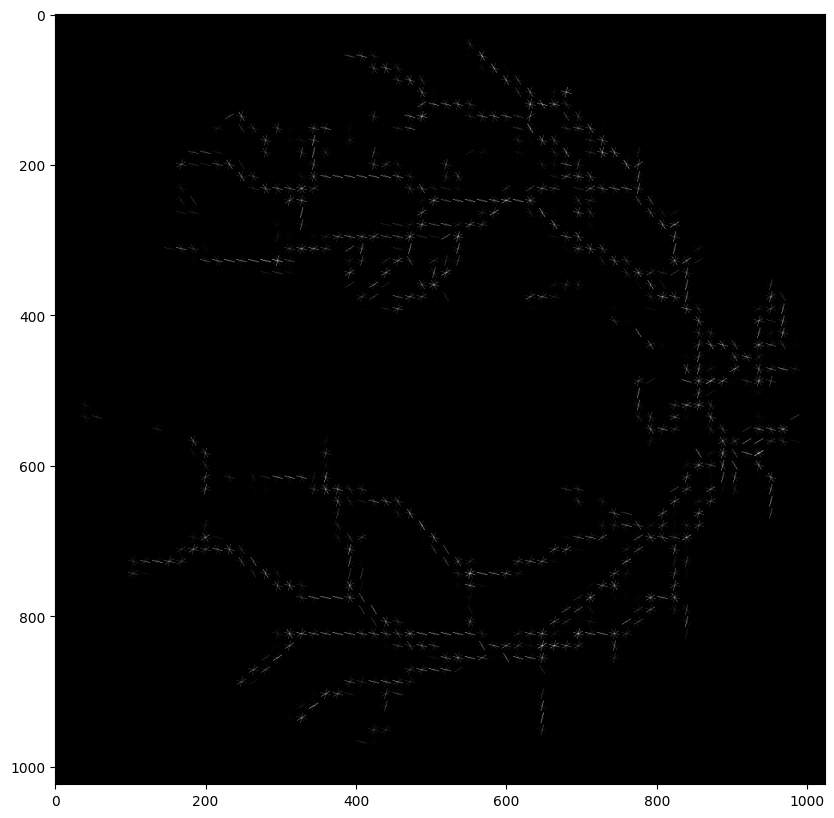

In [36]:
from skimage.feature import hog

out, hog_image = hog(skel.astype(int), orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.imshow(hog_image, cmap="gray")

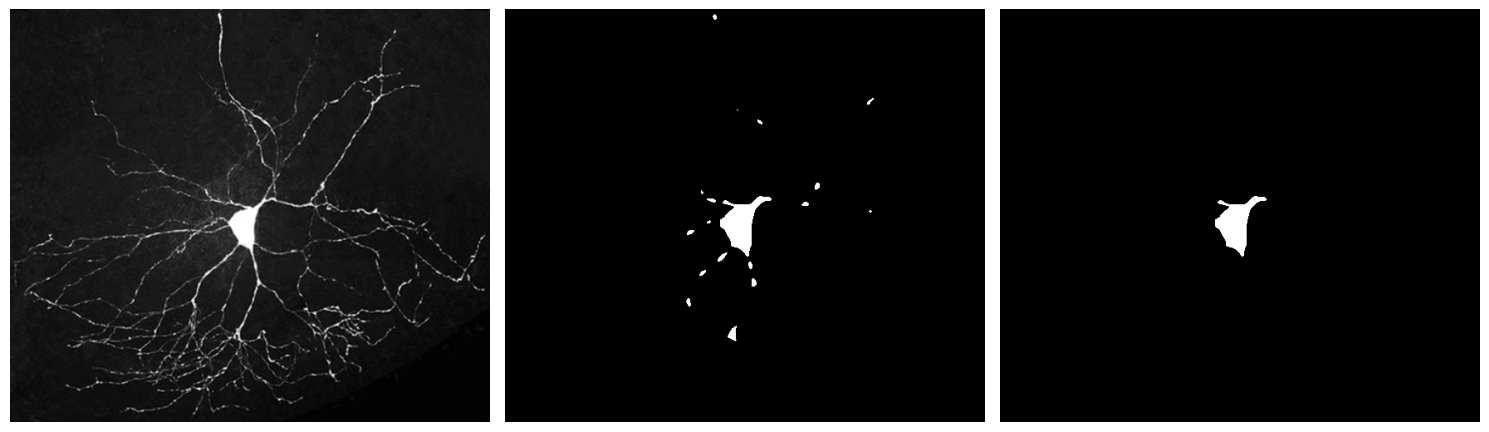

In [37]:
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import binary_opening, binary_closing
from skimage import img_as_float

neuron = imread("neuron_byocitin_Kecskes2013.png")
neuron = img_as_float(neuron)
neuron_thr = threshold_otsu(neuron)
neuron_bin = gaussian(neuron, 3) > neuron_thr

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(neuron, cmap="gray")
ax[1].imshow(neuron_bin, cmap="gray")
ax[2].imshow(remove_small_objects(neuron_bin, min_size=300), cmap="gray")

for a in ax:
    a.axis("off")

plt.tight_layout()